In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Import Dataset

In [2]:
## Construct a dataframe from the csv dataset
colnames=['year', 'month', 'day', 'RMM1', 'RMM2','phase','amplitude','Final_value']
df = pd.read_csv('../mjo_data.csv', sep=r'[ \t]+', names=colnames, skiprows=[0])
total_days = len(df)

## Convert the columns of the dataframe to the numpy array
RMM1 = df['RMM1'].to_numpy(dtype='float64')
RMM2 = df['RMM2'].to_numpy(dtype='float64')
phase = df['phase'].to_numpy(dtype='float64')
amplitude = df['amplitude'].to_numpy(dtype='float64')
raw_datas = [RMM1,RMM2,phase,amplitude]

print(df)

       year  month  day      RMM1      RMM2  phase  amplitude  \
0      1974      6    1  1.634470  1.203040      5   2.029480   
1      1974      6    2  1.602890  1.015120      5   1.897290   
2      1974      6    3  1.516250  1.085510      5   1.864760   
3      1974      6    4  1.509810  1.035730      5   1.830920   
4      1974      6    5  1.559060  1.305180      5   2.033260   
...     ...    ...  ...       ...       ...    ...        ...   
17696  2022     11   12 -0.149320 -0.536245      2   0.556646   
17697  2022     11   13  0.292958 -0.418385      3   0.510755   
17698  2022     11   14  0.638955 -0.395651      4   0.751534   
17699  2022     11   15  0.719955 -0.220695      4   0.753022   
17700  2022     11   16  0.670323 -0.183991      4   0.695116   

                           Final_value  
0       Final_value:__OLR_&_NCEP_winds  
1       Final_value:__OLR_&_NCEP_winds  
2       Final_value:__OLR_&_NCEP_winds  
3       Final_value:__OLR_&_NCEP_winds  
4       Final_

/var/folders/51/_9h2_qzn4b54cgs0qgwxr0vh0000gn/T/ipykernel_59640/2233859504.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../mjo_data.csv', sep=r'[ \t]+', names=colnames, skiprows=[0])


### Specify Initial Values and GP Kernel

In [3]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

n = 10000 # the number of days for training
m = 160 # the number of days for testing
c = 365 # the number of dropped buffer set

n_cv = 1 # the number of operations for cross-validation
n1s = [0]*n_cv
for i in range(n_cv):
    n1s[i] = random.randint(0,n) # (include 0 and n) the number of the first part of the training set


palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

### Dataset Processing and Decomposition

In [4]:
data_names = ['RMM1', 'RMM2', 'phase', 'amplitude']
idx_miss = np.where(RMM1 > 1e34)[0] # index of missing value
n_miss = len(idx_miss) # the number of missing value

def dat_divide(raw_data, idx_miss, n1, m, n, c, fixed_start,start_index, width):
    dic = {}
    dic_ids = {}

    # delete the missing values and their predceding values
    dat = np.delete(raw_data, np.arange(max(idx_miss)+1)) # np.delete(raw_datas[i], idx_miss)

    dic['train1'] = dat[:n1]
    dic_ids['train1'] = np.arange(0,n1)
    if fixed_start:
        dic['test'] = dat[start_index-width:n1+m] # start_index should >= max(width) + r + 1
        dic_ids['test'] = np.arange(start_index-width,n1+m)
    else:
        dic['test'] = dat[n1:n1+m]
        dic_ids['test'] = np.arange(n1,n1+m)
    dic['buffer'] = dat[n1+m:n1+m+c]
    dic['train2'] = dat[n1+m+c:n+m+c]

    dic_ids['buffer'] = np.arange(n1+m, n1+m+c)
    dic_ids['train2'] = np.arange(n1+m+c, n+m+c)
    return dic, dic_ids


def dics_divide(raw_datas, idx_miss, n1, m, n, c, fixed_start=False, start_index=None, width=None):
    dics = {}
    dics_ids = {}
    for raw_data, data_name in zip(raw_datas, data_names):
        dics[data_name], dics_ids = dat_divide(raw_data, idx_miss, n1, m, n, c, fixed_start, start_index, width)
    return dics, dics_ids

# n1 = n1s[0]
# dics, dics_ids = dics_divide(raw_datas, idx_miss, n1, m, n, c, fixed_start=False, start_index=None, width=None)
# print(dics['RMM1']['train1'])

# def dics_tot_divide(raw_datas, idx_miss, n1s, m, n, c, fixed_start=False, start_index=None, width=None):
#     dics_total = {}
#     dics_temp = {}
#     for n1 in n1s:
#         for raw_data, data_name in zip(raw_datas, data_names):
#             dics_temp[data_name], ids_temp = dat_divide(raw_data, idx_miss, n1, m, n, c, fixed_start, start_index, width)
#         dics_total[n1] = dics_temp
#     return dics_total

# dics_total = dics_tot_divide(raw_datas, idx_miss, n1s, m, n, c, fixed_start=False, start_index=None, width=None)
# print(dics_total[n1s[0]]['RMM1']['train1'])

### Independent RMMs with differnet widths in the same plot

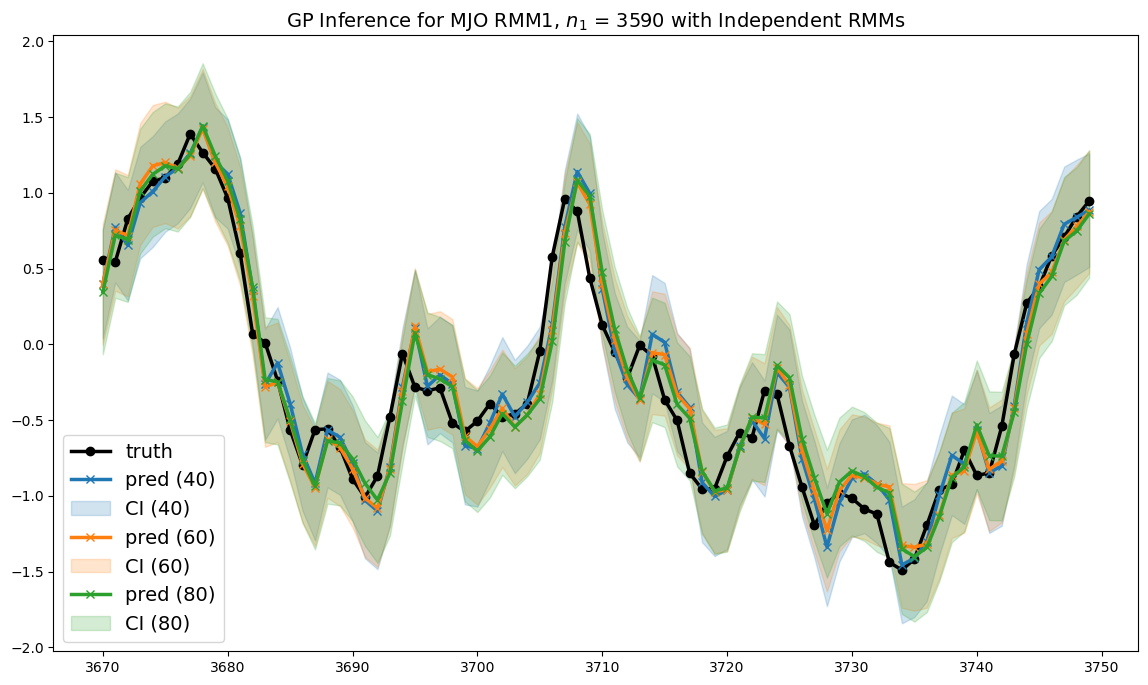

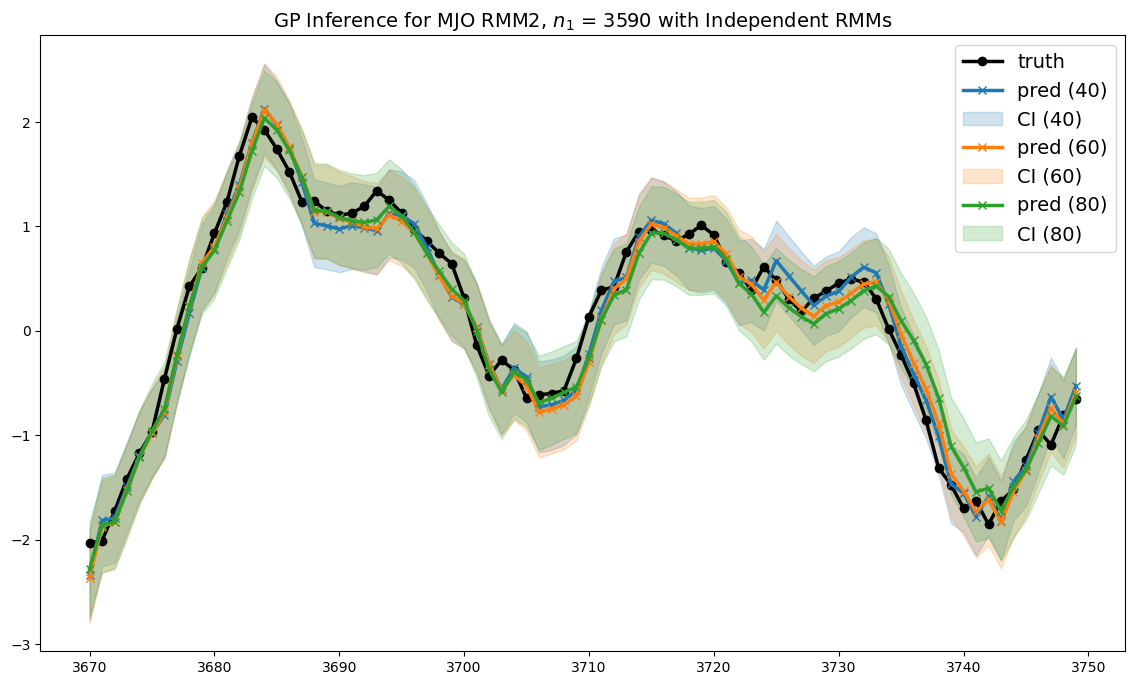

In [6]:
## Independent RMMs in the same plot
for n1 in n1s:
    start_index =  max(widths) + n1 # start_index should >= max(widths) + n1 +1 (start from index=1)
    for data_name in data_names[:2]: # data_names = ['RMM1', 'RMM2', 'phase', 'amplitude'] 
        data_name = data_names[i]
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))  
        for width, color in zip(widths, plot_colors):    
            dics, dics_ids = dics_divide(raw_datas, idx_miss, n1, m, n, c, fixed_start=True, start_index=start_index, width=width)
            if width == widths[0]:
                ax.plot(np.arange(start_index,n1+m), dics[data_name]['test'][width:], color='black', marker='o', linewidth=2.5)
            
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps, fixed_noise)
            mjo_model.train_mjo(data_name)
            mjo_model.pred_mjo(data_name)            
            observed_preds = mjo_model.preds[data_name]
           
            ax.plot(np.arange(start_index,n1+m), observed_preds, color, linewidth=2.5, marker='x')

            lower_confs = mjo_model.lconfs[data_name]
            upper_confs = mjo_model.uconfs[data_name]
            ax.fill_between(np.arange(start_index,n1+m), lower_confs, upper_confs, alpha=0.2, color=color)
        
        if i <= 1:
            ax.legend(['truth',f'pred ({widths[0]})',f'CI ({widths[0]})', f'pred ({widths[1]})',f'CI ({widths[1]})',f'pred ({widths[2]})',f'CI ({widths[2]})'] , fontsize=14)
        else:
            ax.legend(['truth',f'pred ({widths[0]})', f'pred ({widths[1]})',f'pred ({widths[2]})'], fontsize=14)
        ax.set_title(f'GP Inference for MJO {data_name}, $n_1$ = {n1} with Independent RMMs', fontsize=14)
        plt.show()   

### Independent RMMs Examples

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


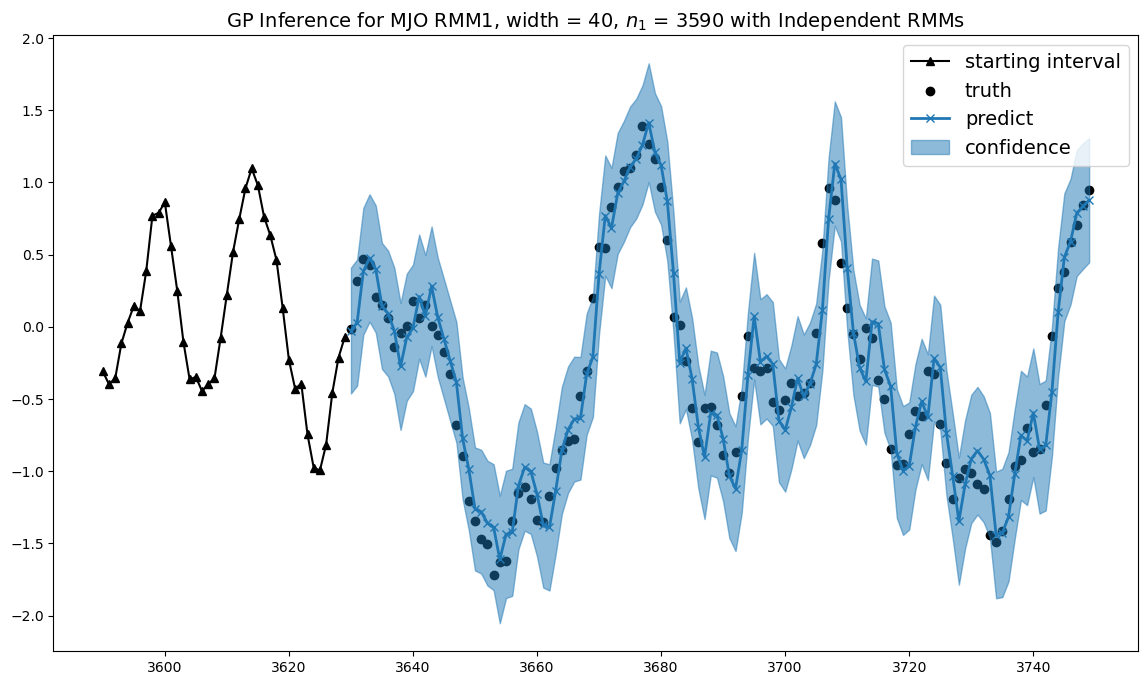

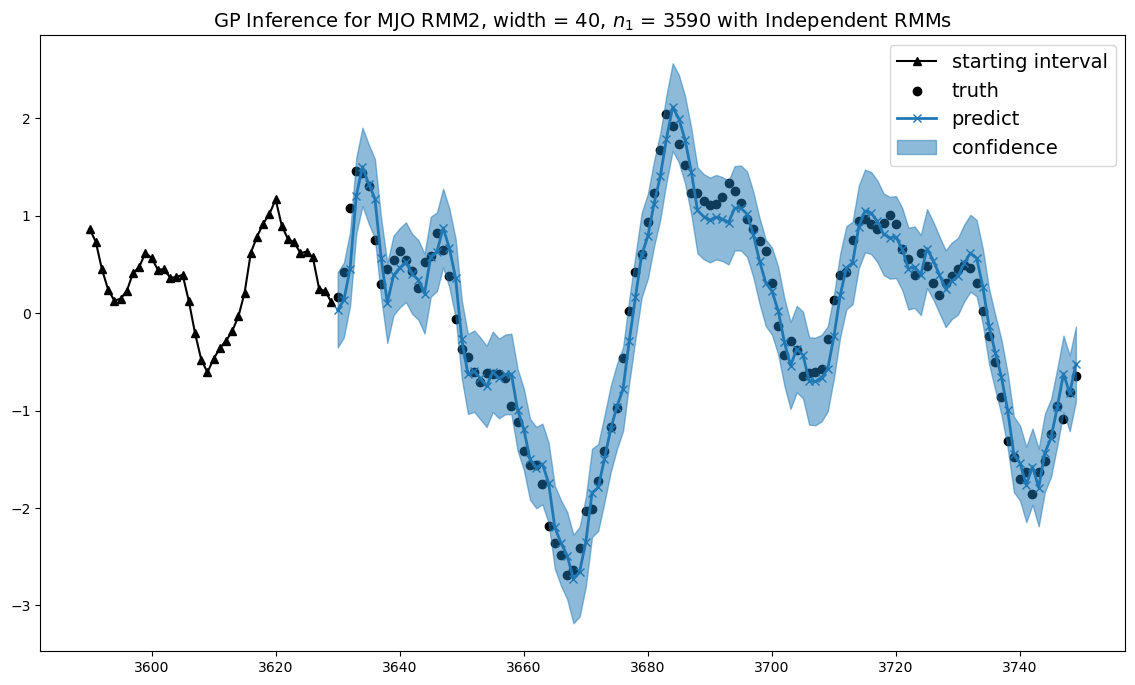

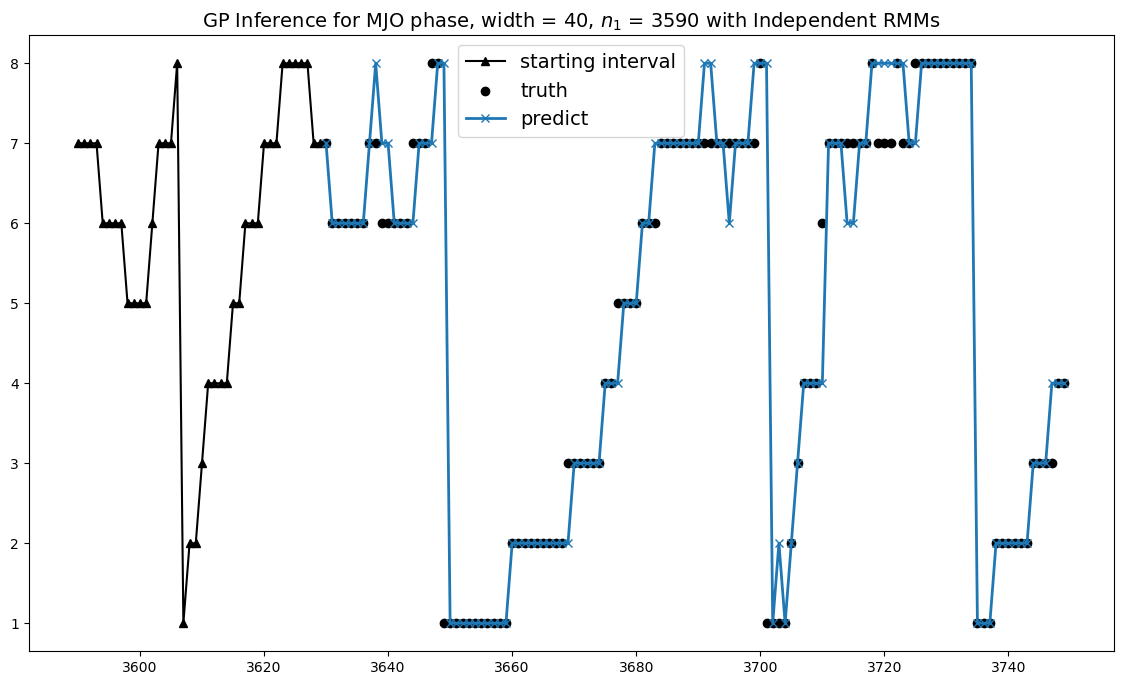

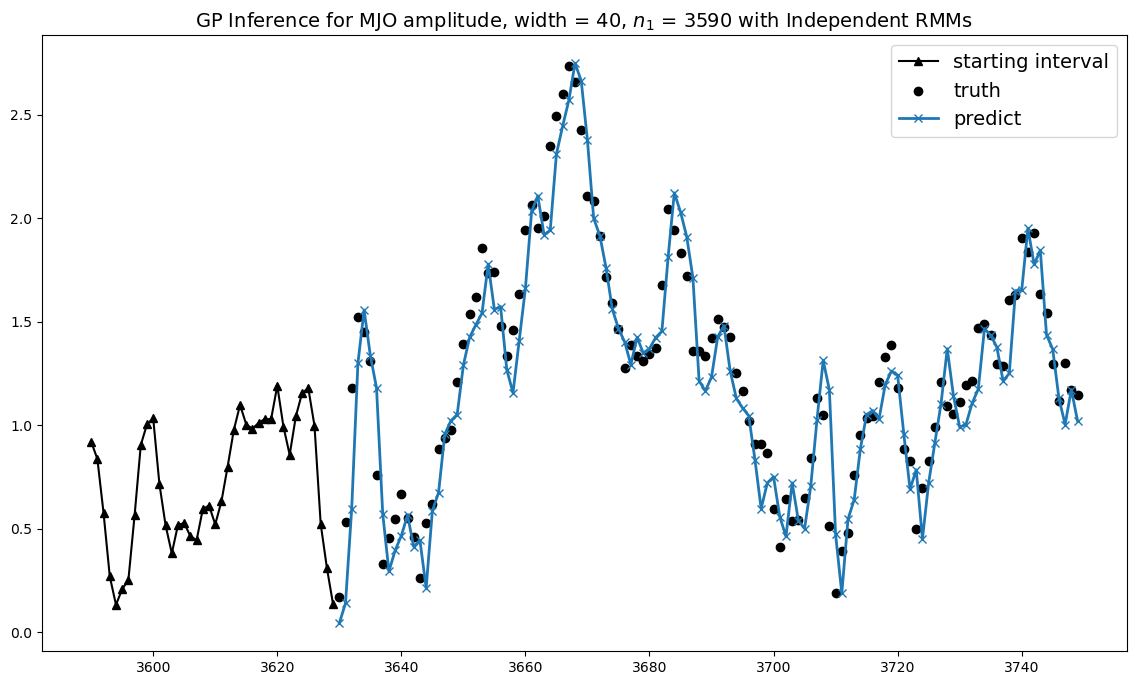

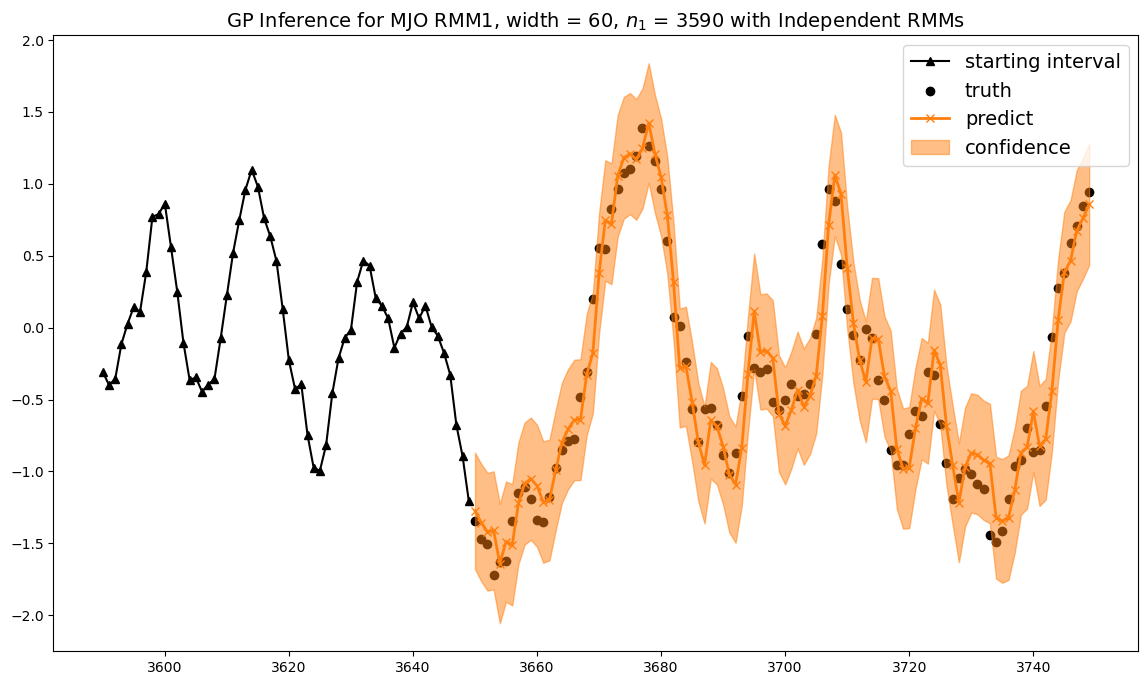

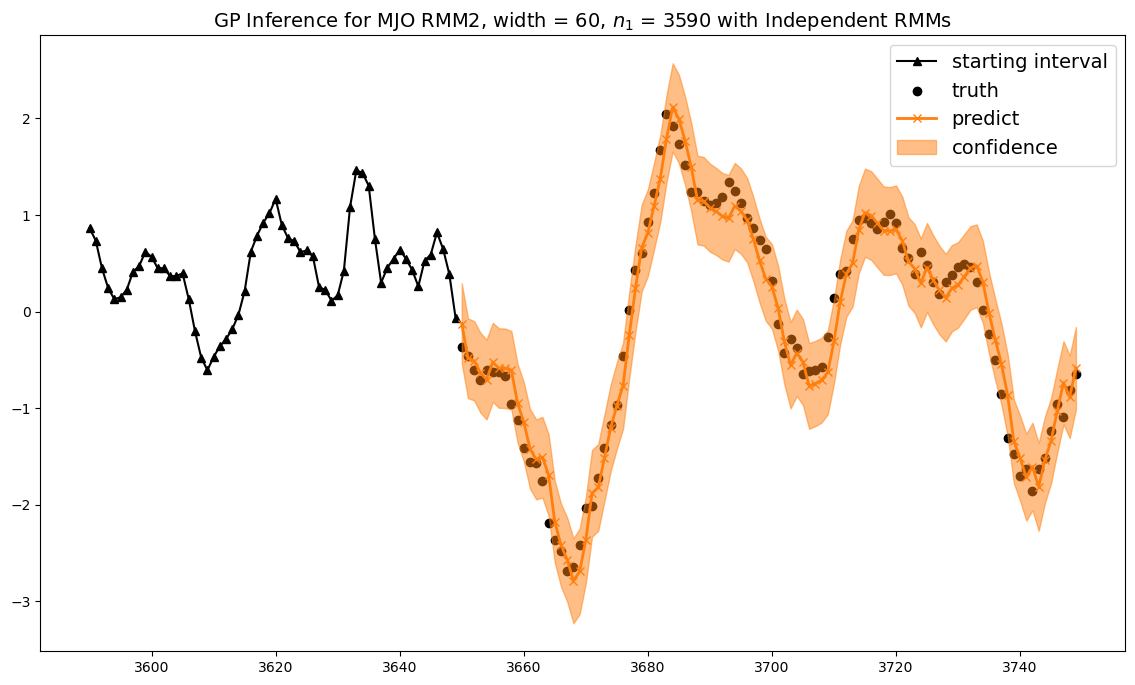

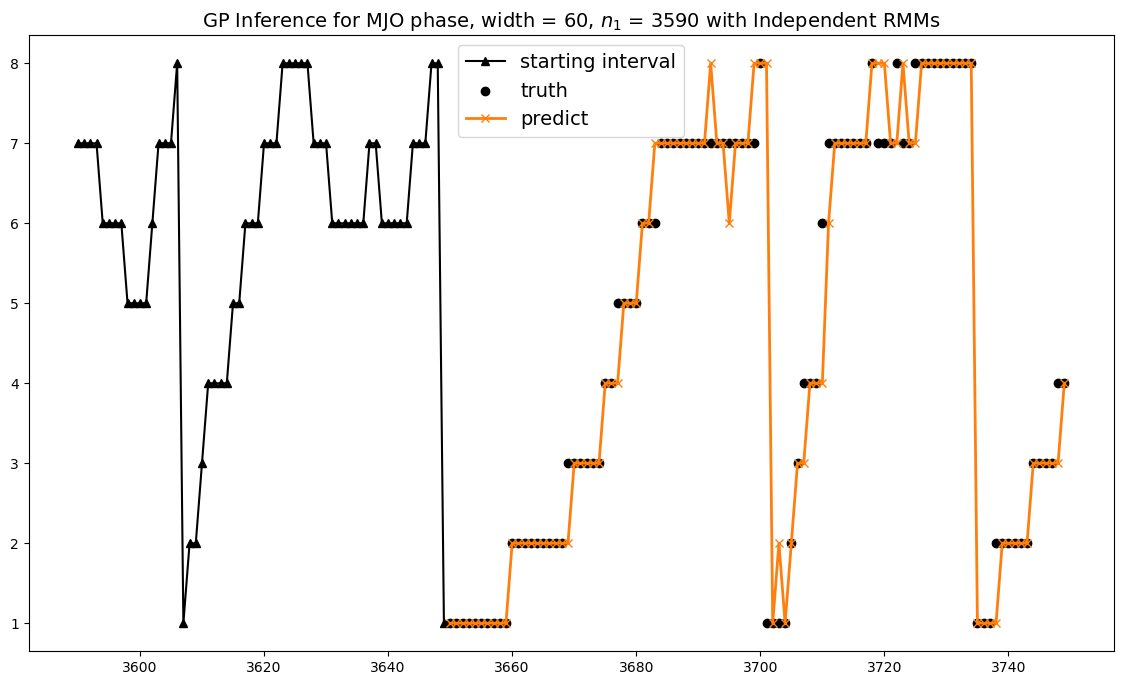

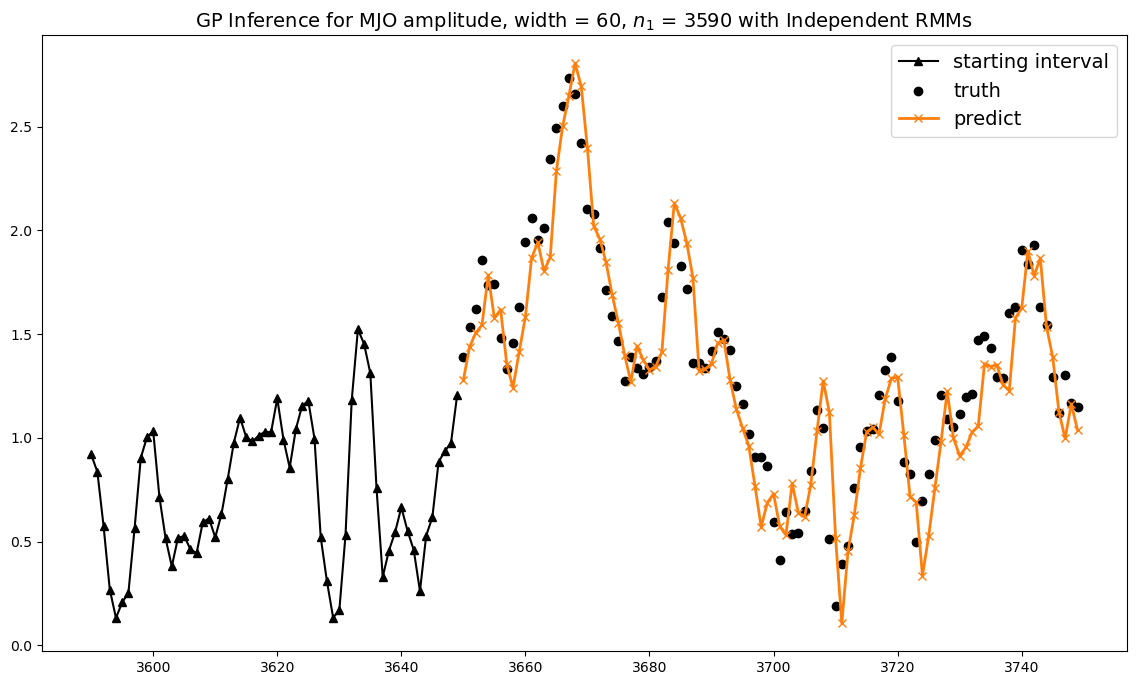

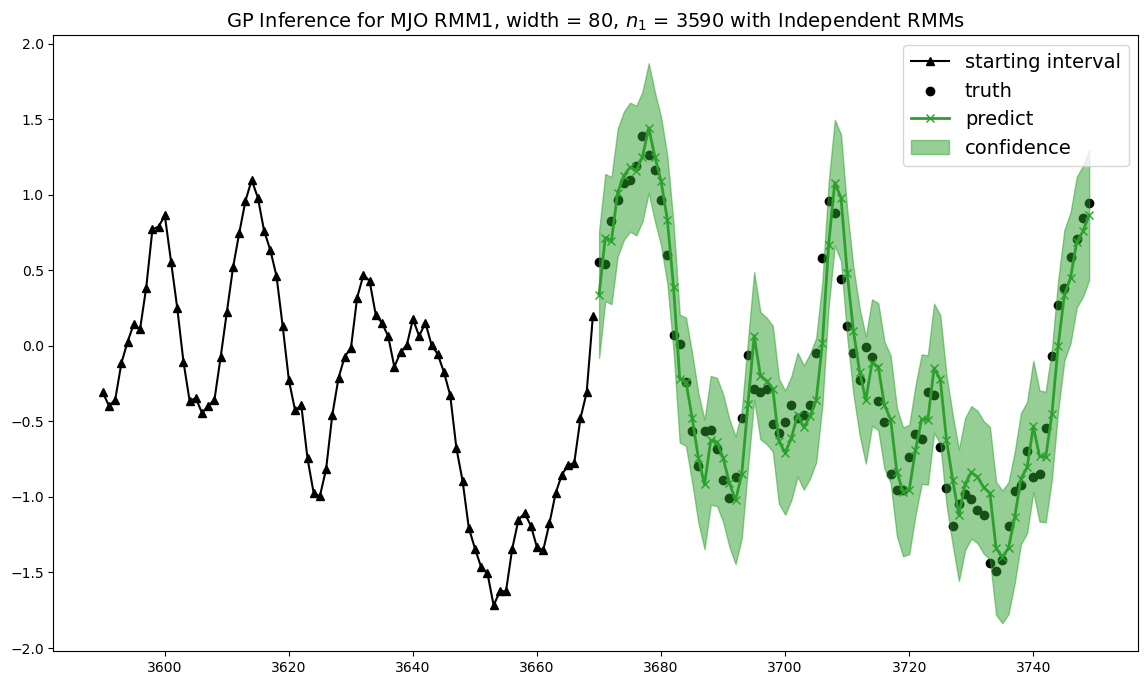

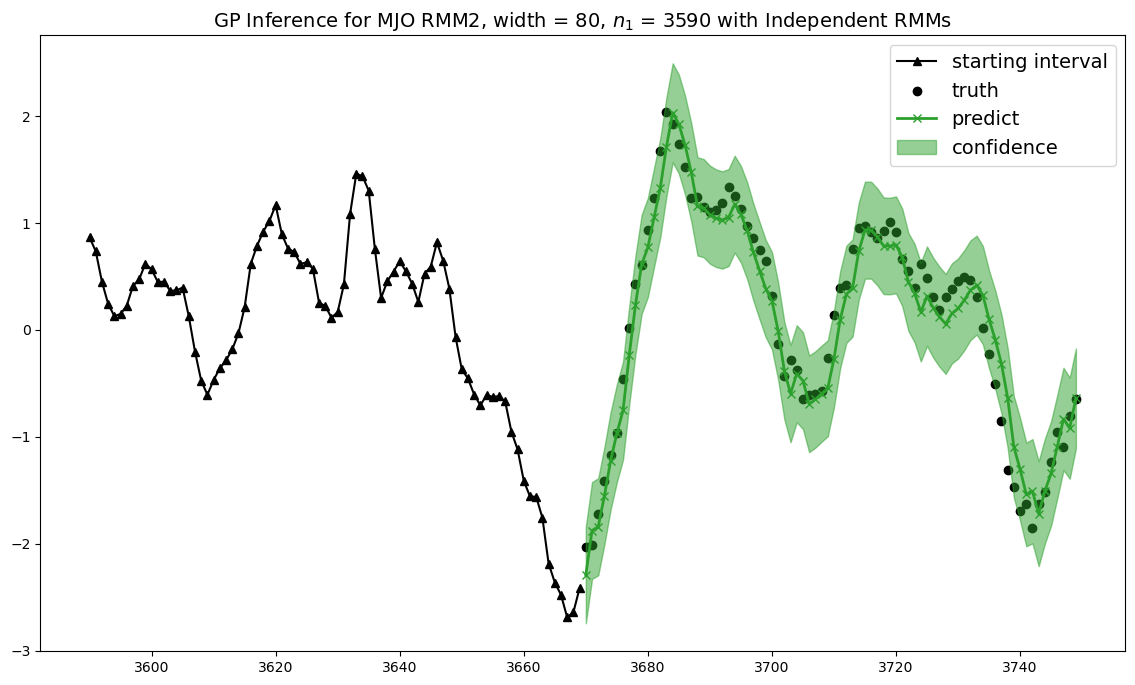

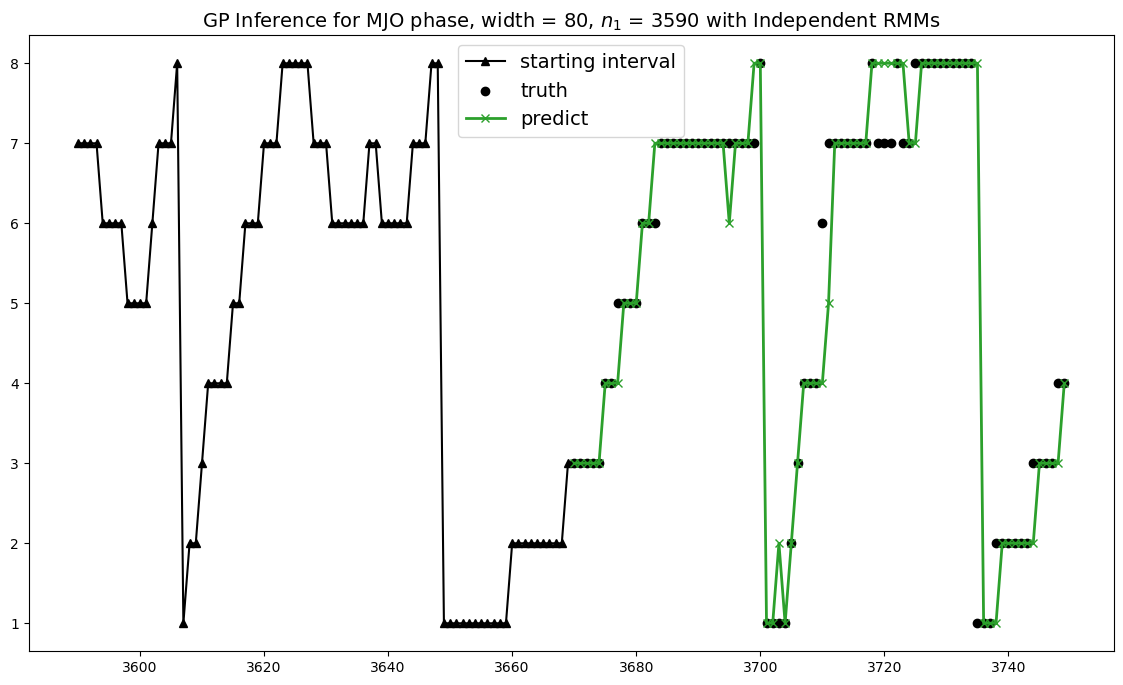

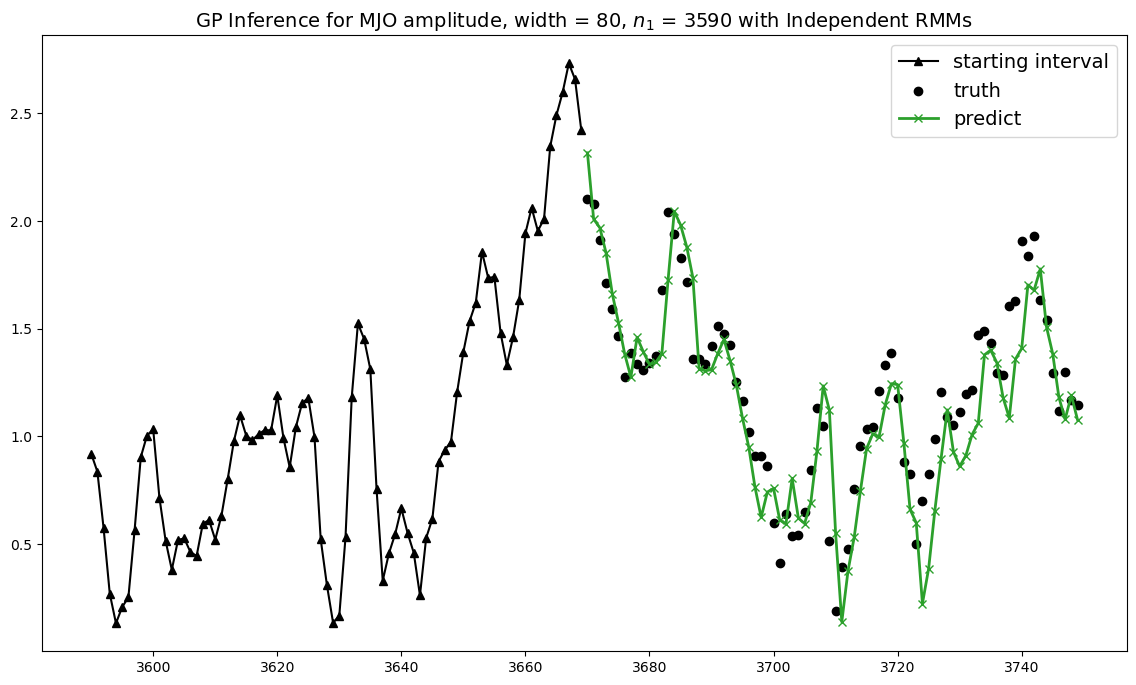

In [5]:
## Independent RMMs
dics_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(raw_datas, idx_miss, n1, m, n, c)
    dics_total[n1] = dics
    for width, color in zip(widths, plot_colors):
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for i in range(4): # data_names = ['RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[i]
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))            
            
            if i <= 1:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name)
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()
            mjo_model.plot_mjo(data_name, ax, color)

            ax.set_title(f'GP Inference for MJO {data_name}, width = {width}, $n_1$ = {n1} with Independent RMMs',fontsize=14)
            plt.show()

### Dependent RMMs Examples

In [ ]:
## Dependent RMMs
dics_total = {}
for data_name in data_names[:2]: # data_names = ['RMM1', 'RMM2', 'phase', 'amplitude']
    for n1 in n1s:
        dics = dics_divide(raw_datas, idx_miss, n1, m, n, c)
        dics_total[n1] = dics
        
        for width, color in zip(widths, plot_colors):            
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))

            mjo_model = gp_mjo(dics, kernel, width, n_iter, sigma_eps,fixed_noise)
            mjo_model.train_mjo(Depend=True)
            mjo_model.pred_mjo(data_name)
            mjo_model.plot_mjo(data_name, ax, color)

            ax.set_title(f'GP Inference for MJO {data_name}, width = {width}, $n_1$ = {n1} with Dependent RMMs')
            plt.show() 